In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

MODEL_PATH = "drive/MyDrive/brain_tumor_project/models/lstm_classifier.pth"

Device: cpu


In [ ]:
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

CLASS_MAP = checkpoint["class_map"]
INV_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

SEQ_LEN = checkpoint["seq_len"]
FEATURE_DIM = checkpoint["feature_dim"]

print("Classes:", CLASS_MAP)

Classes: {'glioma': 0, 'meningioma': 1, 'pituitary': 2, 'notumor': 3}


In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=FEATURE_DIM,
            hidden_size=256,
            num_layers=1,
            batch_first=True
        )
        self.fc = nn.Linear(256, len(CLASS_MAP))

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        return self.fc(out)

In [ ]:
# Load checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)

model = LSTMClassifier().to(DEVICE)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("LSTM model loaded and ready")

LSTM model loaded and ready


In [ ]:
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to(DEVICE)
resnet.eval()

print("ResNet feature extractor ready")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet feature extractor ready


In [ ]:
resnet_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def preprocess_patch_for_resnet(patch):
    patch = (patch * 255).astype("uint8")
    patch = Image.fromarray(patch).convert("RGB")
    return resnet_transform(patch)

In [ ]:
def extract_patches(img, grid=4):
    h, w = img.shape
    ph, pw = h // grid, w // grid

    patches = []
    for i in range(grid):
        for j in range(grid):
            patches.append(img[i*ph:(i+1)*ph, j*pw:(j+1)*pw])

    return patches

In [ ]:
def extract_features_from_image(img, resnet, grid=4):
    patches = extract_patches(img, grid)

    patch_tensors = torch.stack(
        [preprocess_patch_for_resnet(p) for p in patches]
    ).to(DEVICE)

    with torch.no_grad():
        features = resnet(patch_tensors)  # (16, 512)

    return features.unsqueeze(0)  # (1, 16, 512)

In [ ]:
def predict_brain_tumor(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Could not read image")

    img = cv2.resize(img, (224, 224))
    img = img / 255.0

    features = extract_features_from_image(img, resnet)

    with torch.no_grad():
        logits = model(features)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()

    pred_idx = np.argmax(probs)

    return {
        "predicted_class": INV_CLASS_MAP[pred_idx],
        "probabilities": {
            INV_CLASS_MAP[i]: float(probs[i])
            for i in range(len(CLASS_MAP))
        }
    }

In [ ]:
test_image_path = "test_menin.jpg"

result = predict_brain_tumor(test_image_path)

print("Predicted class:", result["predicted_class"])
print("\nClass probabilities:")
for cls, prob in result["probabilities"].items():
    print(f"{cls:12s}: {prob:.4f}")

Predicted class: meningioma

Class probabilities:
glioma      : 0.0000
meningioma  : 1.0000
pituitary   : 0.0000
notumor     : 0.0000


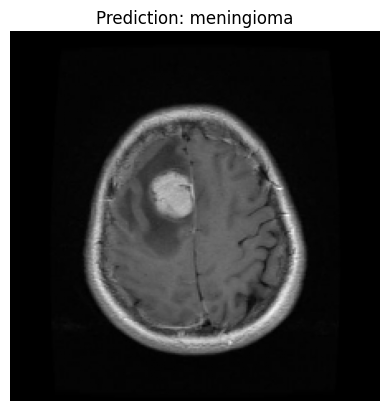

In [ ]:
img = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (224, 224))

plt.imshow(img, cmap="gray")
plt.title(f"Prediction: {result['predicted_class']}")
plt.axis("off")
plt.show()